In [1]:
using Pkg
pkg"activate ."

In [2]:
using PerlaTonettiWaugh, LinearAlgebra, Plots, BenchmarkTools, Interpolations, QuadGK, DifferentialEquations, BlackBoxOptim, Optim, Dierckx

Set up parameters and find the corresponding stationary solution:

In [3]:
z_min = 0.0 
z_max = 5.0
M = 200
z_grid = range(z_min, stop = z_max, length = M) # Since we only care about the grid. 

# Define common objects. 
d_0 = 5
d_T = 2.3701
params = (ρ = 0.02, σ = 4.2508, N = 10, θ = 5.1269, γ = 1.00, κ = 0.013, ζ = 1, η = 0, Theta = 1, χ = 1/(2.1868), υ = 0.0593, μ = 0, δ = 0.053) # Baselines per Jesse. 
δ = params.δ
# solve for stationary solution at t = 0
params_0 = merge(params, (d = d_0,)) # parameters to be used at t = 0
params_T = merge(params, (d = d_T,)) # parameters to be used at t = T


stationary_sol_0 = stationary_numerical(params_0, z_grid) # solution at t = 0
stationary_sol = stationary_numerical(params_T, z_grid) # solution at t = T

Ω_0 = stationary_sol_0.Ω
Ω_T = stationary_sol.Ω
settings = (z = z_grid, tstops = nothing, Δ_E = 1e-06)

println("g = $(stationary_sol.g), z_hat = $(stationary_sol.z_hat), Ω = $(stationary_sol.Ω)")

g = 0.02389665244308684, z_hat = 1.3951350964853995, Ω = 0.9536180359512142


Define the objective function:

In [4]:
function solve_with_candidate(candidate)
    candidate = [candidate...] # if candidate is a tuple, convert it to an array
    T = candidate[end]
    
    candidate = [sort(candidate[1:(end-1)]); 0.0] # fix the point at T to be zero
    
    # construct Ω and E
    E_hat_vec_range = candidate[end] - candidate[1]
    E_hat_vec_scaled = (candidate .- candidate[1]) ./ E_hat_vec_range .- 1.0 
    ts = range(0.0, stop=T, length=length(candidate))
    E_hat_interpolation = CubicSplineInterpolation(ts, E_hat_vec_scaled) # might worth trying cubic spline
    E_hat(t) = E_hat_interpolation(t)

    M = log(Ω_T/Ω_0) / quadgk(E_hat, 0, T)[1]
    Ω_derivative(Ω,p,t) = M*E_hat(t)*Ω
    Ω_solution = try DifferentialEquations.solve(ODEProblem(Ω_derivative,Ω_0,(0.0, T)), reltol = 1e-15) catch; return Inf end
    Ω(t::Float64) = t <= T ? Ω_solution(t) : Ω_solution(T)
    E(t::Float64) = M*E_hat(t) + δ

    # solve the dynamics and get the resulting entry_residual vector; if solution is not valid, return Inf
    return solve_dynamics(params_T, stationary_sol, settings, T, Ω, E; detailed_solution = true)
end

function evaluate_candidate(candidate)
    candidate = [candidate...] # if candidate is a tuple, convert it to an array
    T = candidate[end]
    candidate = [sort(candidate[1:(end-1)]); 0.0] # fix the point at T to be zero
    
    # construct Ω and E
    E_hat_vec_range = candidate[end] - candidate[1]
    E_hat_vec_scaled = (candidate .- candidate[1]) ./ E_hat_vec_range .- 1.0 
    ts = range(0.0, stop=T, length=length(candidate))
    E_hat_interpolation = Spline1D(ts, E_hat_vec_scaled; k = 3) # cubic spline
    
    M = log(Ω_T/Ω_0) / integrate(E_hat_interpolation, 0, T)
    Ω_derivative(Ω,p,t) = M*E_hat_interpolation(t)*Ω
    Ω_solution = try DifferentialEquations.solve(ODEProblem(Ω_derivative,Ω_0,(0.0, T)), reltol = 1e-15) catch; return Inf end
    Ω = t -> t <= T ? Ω_solution(t) : Ω_solution(T)
    E = t -> M*E_hat_interpolation(t) + δ

    # solve the dynamics and get the resulting entry_residual vector; if solution is not valid, return Inf
    solved = try solve_dynamics(params_T, stationary_sol, settings, T, Ω, E; detailed_solution = false).results catch; return Inf end
    
    t = solved.t
    entry_residual = solved.entry_residual

    # interpolate on returned entry_residual
    entry_residual_interpolated = LinearInterpolation(t, entry_residual)

    # evaluate entry_residual on entry_residual_nodes, return the norm
    entry_residuals_nodes = range(0, stop = T, length = ENTRY_RESIDUALS_NODES_COUNT + 2)
    
    entry_residuals_vector = entry_residual_interpolated.(entry_residuals_nodes[2:(end-1)])
    
    return (sqrt(sum(entry_residuals_vector .* WEIGHTS .* entry_residuals_vector)))
end

evaluate_candidate (generic function with 1 method)

Setup for optimizer:

In [5]:
SOLUTION = [-0.29289587818815976; -0.1333218306767743; -0.08942934611931058;  -0.018386019083147458; -0.08930489493014641;  -0.941358463553554;  -0.41788897050932516;  -0.5667354234090646;   -0.01700255640563696;  -0.035690205818277365; -0.7468699888323547;   -0.21670305161145972;  -0.022706851500478447; -0.01700298441332641;  34.99997676121191]    
ENTRY_RESIDUALS_NODES_COUNT = 15
E_NODE_COUNT = 15
MAX_TIME = 600
RANGES_NODES = map(i->(SOLUTION[i] - 1e-5, SOLUTION[i] + 1e-5), 1:(E_NODE_COUNT-1))
RANGES = [RANGES_NODES; (34.5, 36.0)]
WEIGHTS = fill(1, ENTRY_RESIDUALS_NODES_COUNT)
WEIGHTS = [fill(15, 3); fill(1, ENTRY_RESIDUALS_NODES_COUNT-3)];

Find optimal `Ω`:

In [6]:
# result = bboptimize(evaluate_candidate; SearchRange = RANGES, NumDimensions = length(RANGES), MaxTime = MAX_TIME)
# SOLUTION = best_candidate(result)
# result2 = optimize(evaluate_candidate, SOLUTION, BFGS(), Optim.Options(time_limit = MAX_TIME, show_trace = true))
# SOLUTION = result.minimizer

Find the corresponding solution:

In [7]:
solved = solve_with_candidate(SOLUTION)

v_t0 = solved.sol.u[1][1:M]
v0 = solved.results[:v_0]
# save v0 and v_hat_t0
v_hat_t0 = map(z -> exp((params.σ-1)*z), z_grid) .* v_t0;

solved = solved.results;

## Plots for Ω and `entry_residuals`

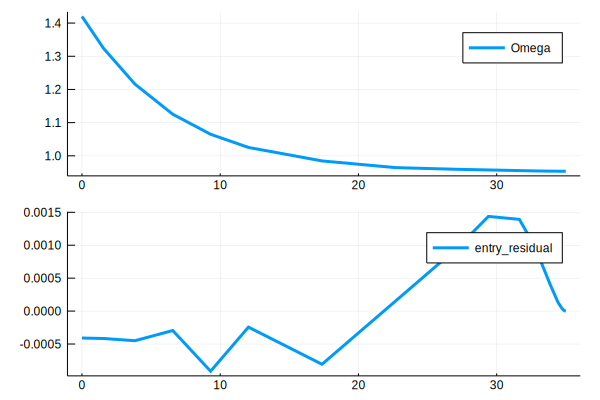

In [8]:
plot_Ω = plot(solved.t, solved.Ω, label = "Omega", lw = 3)
plot_residual = plot(solved.t, solved.entry_residual, label = "entry_residual", lw = 3)
plot(plot_Ω, plot_residual, layout = (2,1))

## Primary Plots

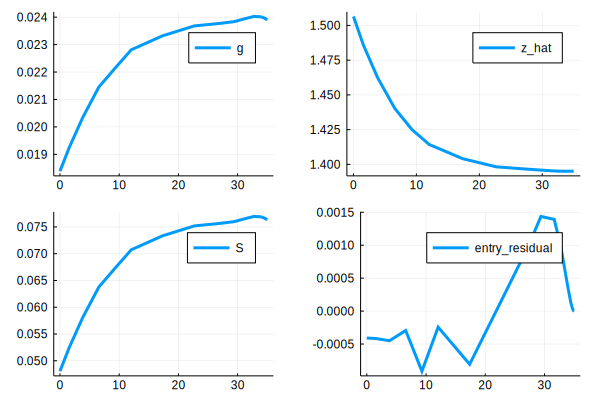

In [9]:
plot1 = plot(solved.t, solved.g, label = "g", lw = 3)
plot2 = plot(solved.t, solved.z_hat, label = "z_hat", lw = 3)
plot3 = plot(solved.t, solved.S, label = "S", lw = 3)
plot4 = plot(solved.t, solved.entry_residual, label = "entry_residual", lw = 3)
plot(plot1, plot2, plot3, plot4, layout=(2,2))

## Static Equations

In [ ]:
plot1 = plot(solved.t, solved.L_tilde, label = "L_tilde", lw = 3)
plot2 = plot(solved.t, solved.z_bar, label = "z_bar", lw = 3)
plot3 = plot(solved.t, solved.π_min, label = "pi_min", lw = 3)
plot4 = plot(solved.t, solved.λ_ii, label = "lambda_ii", lw = 3)
plot5 = plot(solved.t, solved.c, label = "c", lw = 3)
plot6 = plot(solved.t, solved.E, label = "E", lw = 3)
plot7 = plot(solved.t, solved.log_M, label = "log_M", lw = 3)
plot8 = plot(solved.t, solved.U, label = "U", lw = 3)
plot9 = plot(z_grid, v_hat_t0, label = "v_hat at t = 0", lw = 3)
plot(plot1, plot2, plot3, plot4, plot5, plot6, plot7, plot8, layout=(4,2))

## Consumption equivalent for search threshold ($M(0)$)
See computational appendix for details.

### $M(0)$ by two steady states (autarky and steady state at $T$)

In [ ]:
M_0 = exp(params.ρ*(stationary_sol.U_bar - stationary_sol_0.U_bar))

### $M(0)$ by autarky and transition from $t=0$

In [ ]:
M_0 = exp(params.ρ*(solved.U[1] - stationary_sol_0.U_bar))

## Welfare comparison

### $\log M(t)$

In [ ]:
# define log_M with steady state g
log_M_steady_0(t) = stationary_sol_0.g * t
log_M_steady_T(t) = stationary_sol.g * t

# generate the plot!
plot(solved.t, 
    [solved.log_M, log_M_steady_0, log_M_steady_T], 
    label = ["log_M_transition_0", "log_M_steady_0", "log_M_steady_T"] ,
    title = "log_M(t)", linestyle = :auto, lw = 3)

### $\Omega(t)$

In [ ]:
# define Ω function (constant)
Ω_steady_0(t) = stationary_sol_0.Ω
Ω_steady_T(t) = stationary_sol.Ω

# generate the plot!
plot(solved.t, 
    [solved.Ω, Ω_steady_0, Ω_steady_T], 
    label = ["Omega_transition_0", "Omega_steady_0", "Omega_steady_T"] ,
    title = "Omega(t)", linestyle = :auto, lw = 3)

### $c(t)$

In [ ]:
# define c function (constant)
c_steady_0(t) = stationary_sol_0.c
c_steady_T(t) = stationary_sol.c

# generate the plot!
plot(solved.t, 
    [solved.c, c_steady_0, c_steady_T], 
    label = ["c_transition_0", "c_steady_0", "c_steady_T"] ,
    title = "c(t)", linestyle = :auto, lw = 3)